In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Add, BatchNormalization, ZeroPadding2D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, Dense, SeparableConv2D
import matplotlib.pyplot as plt
import pydot as pyd
from IPython.display import SVG
import PIL
from sklearn.model_selection import train_test_split
import os
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tensorflow.keras.models import Model


In [2]:
tf.config.list_physical_devices("GPU") # True/False


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
images = []
labels = ["cat", "dog"]
y = []
data_path = os.getcwd() + "\\data"

for label in labels: 
    image_path = os.path.join(data_path, label) 
    # get images 
    for file in os.listdir(image_path)[:10000]: 
        try: 
            file_path = os.path.join(image_path, file)
            img = PIL.Image.open(file_path)
            # convert to numpy array 
            resized_img = img.resize((96, 96))
            image_matrix = np.asarray(resized_img)
            if image_matrix.shape == (96, 96, 3):                 
                images.append(image_matrix)
                y.append(label)
        except OSError as e:
            print(f"Something wrong with this image : {file_path}")


Something wrong with this image : C:\Users\valentin\Desktop\learn_neural_nets\convolutions\resnet50\data\cat\666.jpg
Something wrong with this image : C:\Users\valentin\Desktop\learn_neural_nets\convolutions\resnet50\data\dog\11702.jpg


In [4]:
images = np.array(images, np.float32)
y = np.array(y)

In [5]:
# normalization 
images = images / 255.0

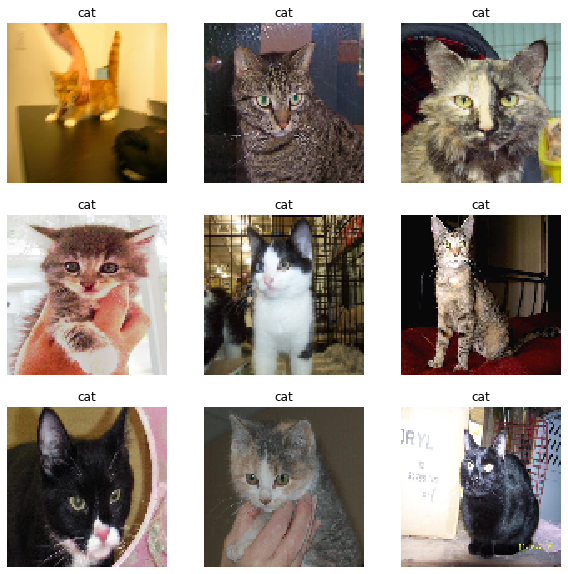

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(y[i])
    plt.axis("off")

In [7]:
# shuffling 
permutation = np.random.permutation(len(images)) 
images = images[permutation]
y = y[permutation]

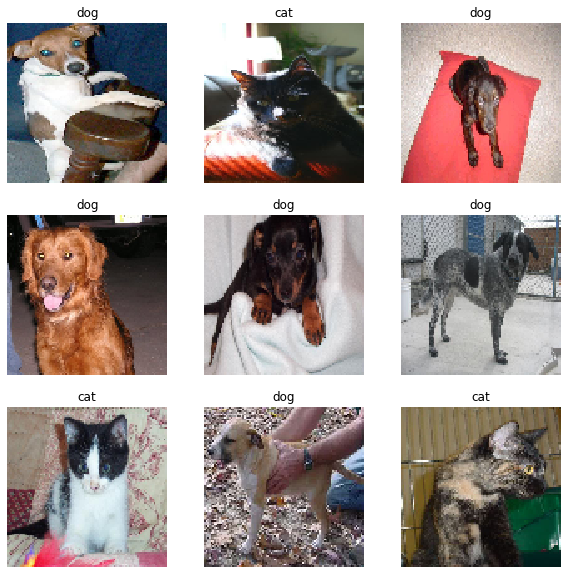

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(y[i])
    plt.axis("off")

In [9]:
y[y == "dog"] = 1 
y[y == "cat"] = 0 
y = y.astype(int)


## Let's start building the network

In [10]:
def residual_block(X_inputs, filters, stride, has_conv=False): 
    
    X_shortcut = X_inputs 
    x = Conv2D(filters[0], 1, padding="valid", strides=stride)(X_inputs) 
    x = BatchNormalization()(x) 
    x = Activation("relu")(x) 

    x = Conv2D(filters[0], 3, padding="same")(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters[1], 1, padding="valid")(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    if has_conv: 
        # convolution on the shortcut 
        X_shortcut = Conv2D(filters[1], 1, padding="valid", strides=stride)(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    
    # add 
    x_out = Add()([x, X_shortcut])
    
    x_out = Activation("relu")(x_out)
    
    return x_out

In [11]:
# x = tf.keras.Input(shape=(28,28, 512))
# residual_block(x, [256, 1024],reduce=True)

In [12]:
def resent50(input_shape, classes): 
    
    # data augmentation thing 
        
    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)(x)
    
    x = Conv2D(64, 7, padding="valid", strides=2)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    
    x = MaxPooling2D(3, strides=2, padding="valid")(x) 
    
    x = residual_block(x, [64, 256], 1, has_conv=True) 
    x = residual_block(x, [64, 256], 1, has_conv=False)
    x = residual_block(x, [64, 256], 1, has_conv=False)
    
    # reduce 
    
    x = residual_block(x, [128, 512], 2, has_conv=True)
    x = residual_block(x, [128, 512], 1, has_conv=False)
    x = residual_block(x, [128, 512], 1, has_conv=False)
    x = residual_block(x, [128, 512], 1, has_conv=False)
    
    # reduce 
    x = residual_block(x, [256, 1024], 2, has_conv=True)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    x = residual_block(x, [256, 1024], 1, has_conv=False)
    
    # reduce
    x = residual_block(x, [512, 2048], 2, has_conv=True)
    x = residual_block(x, [512, 2048], 1, has_conv=False)
    x = residual_block(x, [512, 2048], 1, has_conv=False)
    
    # dense 
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    if classes == 2: 
        unit = 1 
        activation = "sigmoid"
    else: 
        unit = classes 
        activation = "softmax"
        
    x = Dense(unit, activation=activation)(x)
    
    
    model = Model(inputs, x)
    
    return model

    

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, shuffle=True)

In [14]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [15]:
model = resent50((96, 96, 3), 2)

In [16]:
def scheduler(epoch, lr): 
    if lr > 7: 
        return lr * tf.math.exp(-0.1 * epoch)
    return lr

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(
    tf.keras.optimizers.SGD(0.01), 
    "binary_crossentropy", 
    ["accuracy"]
)
log_dir = "logs/fit/resnet50_with_lr_scheduling_v2" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    X_train, y_train, epochs=100, batch_size=32, callbacks=[lr_schedule, tensorboard_callback], validation_data=(X_test, y_test),
)


Epoch 1/100
499/499 [==============================] - 100s 157ms/step - loss: 1.9223 - accuracy: 0.5212 - val_loss: 1.9272 - val_accuracy: 0.5879
Epoch 2/100
499/499 [==============================] - 71s 143ms/step - loss: 0.9352 - accuracy: 0.5693 - val_loss: 0.9204 - val_accuracy: 0.5488
Epoch 3/100
499/499 [==============================] - 72s 144ms/step - loss: 0.7732 - accuracy: 0.6352 - val_loss: 2.1177 - val_accuracy: 0.5668
Epoch 4/100
499/499 [==============================] - 71s 143ms/step - loss: 0.6701 - accuracy: 0.6883 - val_loss: 1.1349 - val_accuracy: 0.5290
Epoch 5/100
499/499 [==============================] - 71s 143ms/step - loss: 0.5916 - accuracy: 0.7261 - val_loss: 0.7395 - val_accuracy: 0.6022
Epoch 6/100
499/499 [==============================] - 71s 143ms/step - loss: 0.5171 - accuracy: 0.7557 - val_loss: 0.7912 - val_accuracy: 0.6460
Epoch 7/100
499/499 [==============================] - 72s 143ms/step - loss: 0.4651 - accuracy: 0.7848 - val_loss: 0.6275 

In [ ]:
model.compile(
    tf.keras.optimizers.SGD(0.0001), 
    "binary_crossentropy", 
    ["accuracy"]
)
log_dir = "logs/fit/resnet50_with_lr_scheduling_v3" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    X_train, y_train, epochs=100, batch_size=64, callbacks=[lr_schedule, tensorboard_callback], validation_data=(X_test, y_test),
)
